In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [2]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
bde = pd.read_csv('20200614_rdf_new_elements.csv.gz', index_col=0)

train = bde[bde.set == 'train'].molecule.unique()
valid = bde[bde.set == 'valid'].molecule.unique()
test = bde[bde.set == 'test'].molecule.unique()

from preprocess_inputs import preprocessor
preprocessor.from_json('tfrecords/preprocessor.json')

In [4]:
test_dataset = tf.data.Dataset.from_generator(
    lambda: (preprocessor.construct_feature_matrices(smiles, train=False) for smiles in test),
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=128, padded_shapes=preprocessor.padded_shapes(max_bonds=64),  # explicit padding required for consistent output shape
                  padding_values=preprocessor.padding_values)

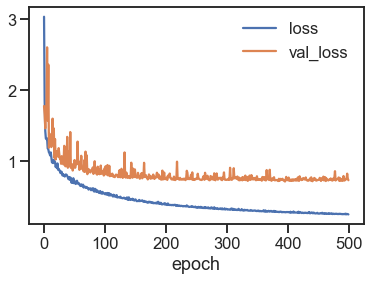

In [5]:
pd.read_csv('20200614_trained_model/log.csv').set_index('epoch').plot()

In [6]:
pd.read_csv('20200614_trained_model/log.csv').min()

epoch       0.000000
loss        0.253398
val_loss    0.716516
dtype: float64

In [7]:
import nfp

In [8]:
model = tf.keras.models.load_model('20200614_trained_model/best_model.hdf5', custom_objects=nfp.custom_objects)

In [9]:
predicted_bdes = model.predict(test_dataset, verbose=True)

pivot_bdes = bde[bde.molecule.isin(test)].pivot(index='molecule', columns='bond_index', values='bde').reindex(test).values
predicted_bdes = predicted_bdes[:, :pivot_bdes.shape[1], 0]

8/8 [==============================] - 4s 455ms/step


In [10]:
predicted_bdes[0]

array([120.90864   , 113.24419   ,  91.3298    ,  86.66288   ,
        85.99911   ,  87.18898   ,  87.18899   ,  85.999115  ,
        86.66288   , 131.63138   ,  79.380875  ,  79.380875  ,
       110.92064   , 111.09738   , 111.32838   , 111.097374  ,
       110.92065   ,   0.13994144,   0.13994144,   0.13994144,
         0.13994144,   0.13994144,   0.13994144,   0.13994144,
         0.13994144,   0.13994144,   0.13994144,   0.13994144,
         0.13994144,   0.13994144], dtype=float32)

In [11]:
pivot_bdes[0]

array([         nan, 113.10347718,  90.33807817,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,  79.15084772,  79.15084772,
       111.00257705, 111.0063421 , 111.3897501 , 111.0063421 ,
       111.00257705,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan])

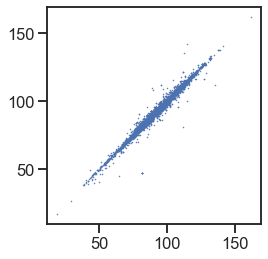

In [12]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')

_ = plt.plot(predicted_bdes, pivot_bdes, '.', color='b', ms=1)

In [13]:
np.nanmean(np.abs(predicted_bdes - pivot_bdes))

0.6558908738251576

In [ ]:
all_mols = bde.molecule.unique()

bde_dataset = tf.data.Dataset.from_generator(
    lambda: (preprocessor.construct_feature_matrices(smiles, train=False) for smiles in all_mols),
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=128, padded_shapes=preprocessor.padded_shapes(max_bonds=64),  # explicit padding required for consistent output shape
                  padding_values=preprocessor.padding_values)

In [ ]:
model.layers[-7].output

In [ ]:
embedding_model = tf.keras.Model(model.inputs, [model.layers[-7].output])
embeddings = embedding_model.predict(bde_dataset, verbose=True)

In [ ]:
embeddings.shape

In [ ]:
bond_indices = np.concatenate([np.arange(32) for _ in all_mols])
mols = np.concatenate([np.array([mol] * 32) for mol in all_mols])

index_df = pd.DataFrame(mols, columns=['molecule'])
index_df['bond_index'] = bond_indices

embed_df = pd.DataFrame(embeddings[:, :32, :].reshape((-1, 128)))
embed_df = embed_df.join(index_df).set_index(['molecule', 'bond_index'])

In [ ]:
bde = bde.sort_values('rid').reset_index()
embed_df = embed_df.reindex(bde[['molecule', 'bond_index']])

In [ ]:
bde[(bde.molecule == 'CCc1cc(O)cc(O)c1') & (bde.bond_index == 16)]

In [ ]:
embed_df.iloc[89329]

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=(
    ('PCA', PCA(n_components=10)),
    ('NearestNeighbors', NearestNeighbors(n_neighbors=10))
))

pipe.fit(embed_df.values)

In [ ]:
test_bond_embeddings = embed_df[embed_df.index.isin(test, level=0)].values

In [ ]:
def pipe_kneighbors(pipe, X):
    Xt = pipe.steps[0][-1].transform(X)
    return pipe.steps[-1][-1].kneighbors(Xt)

distances, indices = pipe_kneighbors(pipe, test_bond_embeddings)

In [ ]:
indices

In [ ]:
distances[:, :5]

In [ ]:
import joblib
joblib.dump(pipe, '20200615_bond_embedding_nbrs.p.z', compress=True)  

In [ ]:
bde.to_csv('20200615_bonds_for_neighbors.csv.gz', compression='gzip', index=False)

In [ ]:
ds = tf.data.Dataset.from_generator(
    lambda: (preprocessor.construct_feature_matrices(smiles, train=False) for smiles in ('Oc1cccc(O)c1',)),
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .batch(1)

distances, indices = pipe_kneighbors(pipe, embedding_model.predict(ds)[:, 8, :])

In [ ]:
distances

In [ ]:
indices

In [ ]:
bde.reindex(indices.flatten())

In [ ]:
pipe_kneighbors(pipe, np.atleast_2d(embed_df.loc['CCc1cc(O)cc(O)c1', 16].values))

In [ ]:
embed_df.iloc[105390]

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
from IPython.display import SVG

In [ ]:
diclofenac = Chem.MolFromSmiles('CCC(CC)COC(=O)[C@H](C)NP(=O)(OC[C@H]1O[C@@](C#N)(c2ccc3c(N)ncnn23)[C@H](O)[C@@H]1O)Oc1ccccc1')
d2d = rdMolDraw2D.MolDraw2DSVG(500, 500)

opts = d2d.drawOptions()
#opts.fixedBondLength=50
#opts.bondLineWidth=1

d2d.DrawMolecule(diclofenac)
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())

In [ ]:
opts.highlightBondWidthMultiplier = 20